In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import calendar
import stats_mca_gemini as smg
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt

In [2]:
path = '../../data0/yvu/MERRA-2/temperature/' 
file = "merged-M2TMNXSLV.nc4"# just 2-m temperature
ds = xr.open_dataset(path+file).sortby('time')
file = '../MERRA2_101.const_2d_asm_Nx.00000000.nc4'# constants (land-sea mask, geopotential height, etc.)
constants = xr.open_dataset(path+file)
lsm = constants.FRLAND.squeeze(dim='time')
constants.close()

ds = ds * lsm

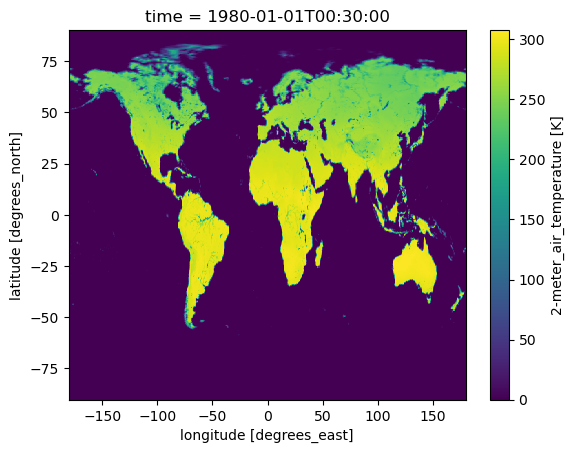

In [3]:
ds.T2M.isel(time=0).plot()

# siberia line graphs and average anomaly calculations

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.


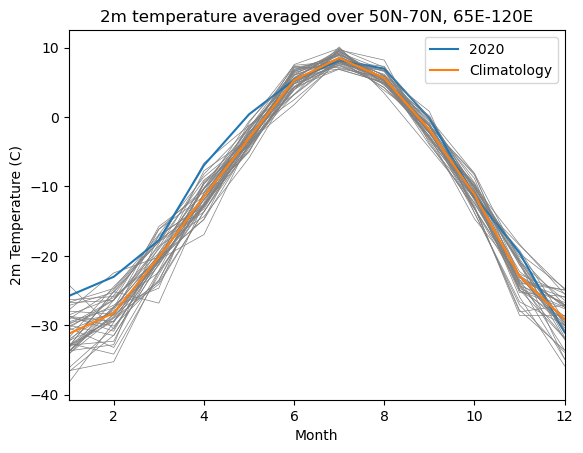

In [4]:
region=smg.siberia
month_start=1
month_end=12
min_lat = 50
max_lat = 70
min_lon = 65
max_lon = 120
var='T2M'

ds_regional = smg.select_region_and_time(ds, month_start, month_end, region=region)

# 2. Apply latitude weighting for accurate spatial averaging
weights = np.cos(np.deg2rad(ds_regional.latitude))
weights.name = "weights"

# 3. Select the variable and calculate anomalies based on the climatology for 1951-1980
ds_regional = ds_regional[var]
clim = ds_regional.weighted(weights).mean(dim=('longitude', 'latitude'))
clim = clim.groupby('time.month').mean(dim='time')

# plot single years in thin grey line
for i, year in enumerate(np.arange(1980,2024)):
    ds_year = ds_regional.isel(time=(ds.time.dt.year == year))
    ds_year = ds_year.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon,max_lon))
    ds_year = ds_year.weighted(weights).mean(dim=('longitude', 'latitude'))
    if year == 2020:
        plt.plot(clim.month, ds_year-273.15,label="2020")
    else:
        plt.plot(clim.month, ds_year-273.15,linewidth=0.5, color='grey')

plt.plot(clim.month, clim-273.15, label="Climatology")
plt.xlim(1,12)
plt.xlabel("Month")
plt.ylabel("2m Temperature (C)")
plt.title("2m temperature averaged over 50N-70N, 65E-120E")
plt.legend()

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 5.


Text(0.5, 1.0, 'Siberia (50-70N, 65-120E) Average Jan-May 2m Temperature Anomaly')

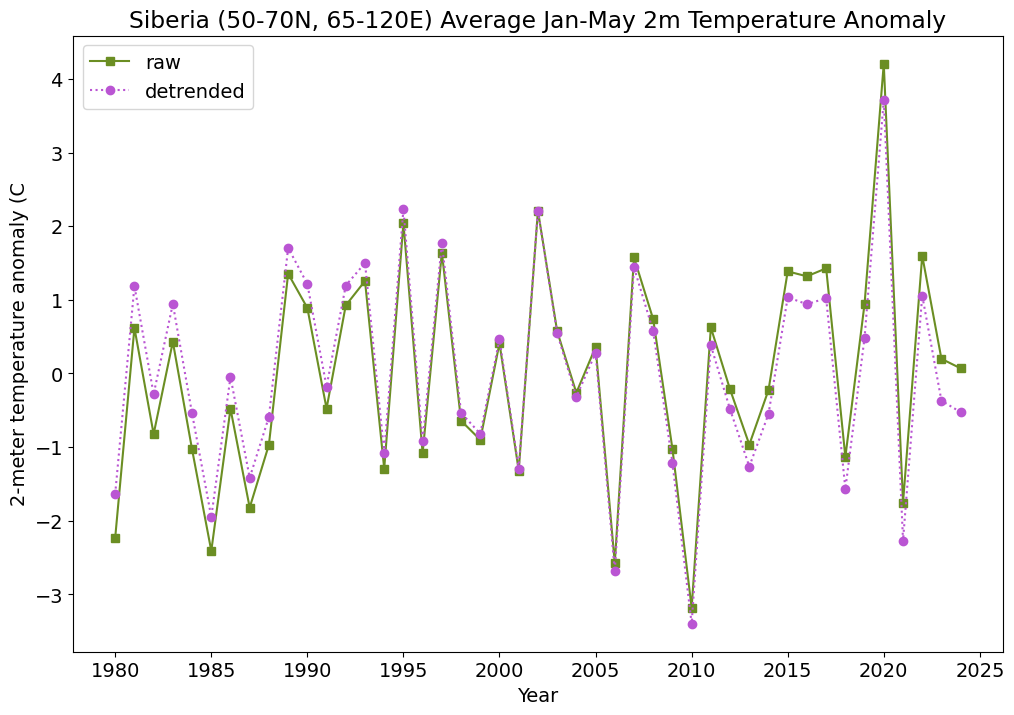

In [5]:
region=smg.siberia
month_start=1
month_end=5
var='T2M'

ds_regional = smg.select_region_and_time(ds, month_start, month_end, region=region)

# 2. Apply latitude weighting for accurate spatial averaging
weights = np.cos(np.deg2rad(ds_regional.latitude))
weights.name = "weights"

# 3. Select the variable and calculate anomalies based on the climatology for 1951-1980
ds_regional = ds_regional[var]
clim = ds_regional.groupby('time.month').mean(dim='time')
anom = ds_regional.groupby('time.month') - clim

# 4. Spatially average the anomalies to get a single time series
anom = anom.weighted(weights).mean(dim=('longitude', 'latitude'))

# 5. Detrend the resulting time series
anom_detrend = smg.detrend_dataarray(anom)

# 6. Take yearly average
anom=anom.resample(time='YS').mean()
anom_detrend=anom_detrend.resample(time='YS').mean()

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 14})
anom.plot.line('-s',color='olivedrab',label="raw")
anom_detrend.plot.line(':o',color='mediumorchid',label="detrended")
plt.xlabel("Year")
plt.ylabel("2-meter temperature anomaly (C")
plt.legend()
plt.title("Siberia (50-70N, 65-120E) Average Jan-May 2m Temperature Anomaly")

# standardized anomaly, 2m temperature

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
The detrended 2m temperature in Siberia during 2020 was 0.81 times the standard the deviation


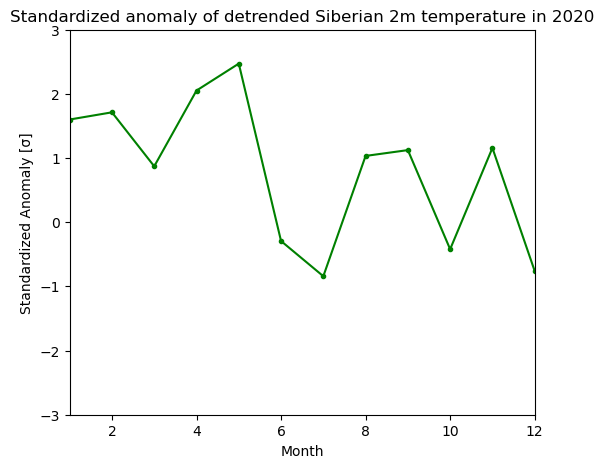

In [6]:
# DETRENDED VERSION (all steps)
# calculate where 2020 lies in the standard deviation
region=smg.siberia
month_start=1
month_end=12
var='T2M'

ds_regional = smg.select_region_and_time(ds, month_start, month_end, region=region)

# 2. Apply latitude weighting for accurate spatial averaging
weights = np.cos(np.deg2rad(ds_regional.latitude))
weights.name = "weights"

# 3. Select the variable and calculate anomalies based on the climatology for 1951-1980
ds_regional = ds_regional[var]
clim = ds_regional.groupby('time.month').mean(dim='time')
anom = ds_regional.groupby('time.month') - clim

# 4. Spatially average the anomalies to get a single time series
anom = anom.weighted(weights).mean(dim=('longitude', 'latitude'))

# 5. Detrend the resulting time series
anom_detrend = smg.detrend_dataarray(anom)

# 6. Standardize the detrended anomalies
# The anomaly is standardized by the standard deviation of that month's anomalies
monthly_std = anom_detrend.groupby('time.month').std(dim='time')
anom_detrend_standardized = anom_detrend.groupby('time.month') / monthly_std

print("The detrended 2m temperature in Siberia during 2020 was "+str(np.round(anom_detrend_standardized.sel(time="2020").mean().values,2))+" times the standard the deviation")

std_anom_detrend_2020=anom_detrend_standardized.sel(time="2020")
plt.rcParams.update({'figure.figsize': (6,5),
                    'font.size': 10})
plt.plot(std_anom_detrend_2020.month,std_anom_detrend_2020,'g.-')
plt.xlabel("Month")
plt.xlim(1,12)
plt.ylabel("Standardized Anomaly [σ]")
plt.ylim(-3,3)
plt.title("Standardized anomaly of detrended Siberian 2m temperature in 2020")
plt.show()

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
The detrended 2m temperature in Siberia during 2020 was 1.04 times the standard the deviation


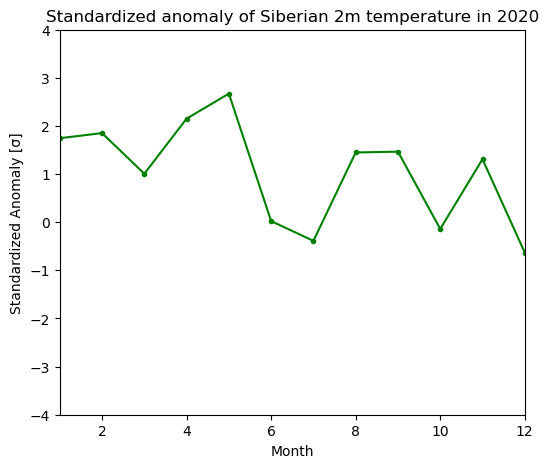

In [7]:
# With Linear trend (all Steps)
# calculate where 2020 lies in the standard deviation
region=smg.siberia
month_start=1
month_end=12
var='T2M'

ds_regional = smg.select_region_and_time(ds, month_start, month_end, region=region)

# 2. Apply latitude weighting for accurate spatial averaging
weights = np.cos(np.deg2rad(ds_regional.latitude))
weights.name = "weights"

# 3. Select the variable and calculate anomalies based on the climatology for 1951-1980
ds_regional = ds_regional[var]
clim = ds_regional.groupby('time.month').mean(dim='time')
anom = ds_regional.groupby('time.month') - clim

# 4. Spatially average the anomalies to get a single time series
anom = anom.weighted(weights).mean(dim=('longitude', 'latitude'))

# 5. Standardize the anomalies
# The anomaly is standardized by the standard deviation of that month's anomalies
monthly_std = anom.groupby('time.month').std(dim='time')
anom_standardized = anom.groupby('time.month') / monthly_std

print("The detrended 2m temperature in Siberia during 2020 was "+str(np.round(anom_standardized.sel(time="2020").mean().values,2))+" times the standard the deviation")
std_anom_2020=anom_standardized.sel(time="2020")
plt.rcParams.update({'figure.figsize': (6,5),
                    'font.size': 10})
plt.plot(std_anom_2020.month,std_anom_2020,'g.-')
plt.xlabel("Month")
plt.xlim(1,12)
plt.ylabel("Standardized Anomaly [σ]")
plt.ylim(-4,4)
plt.title("Standardized anomaly of Siberian 2m temperature in 2020")
plt.show()

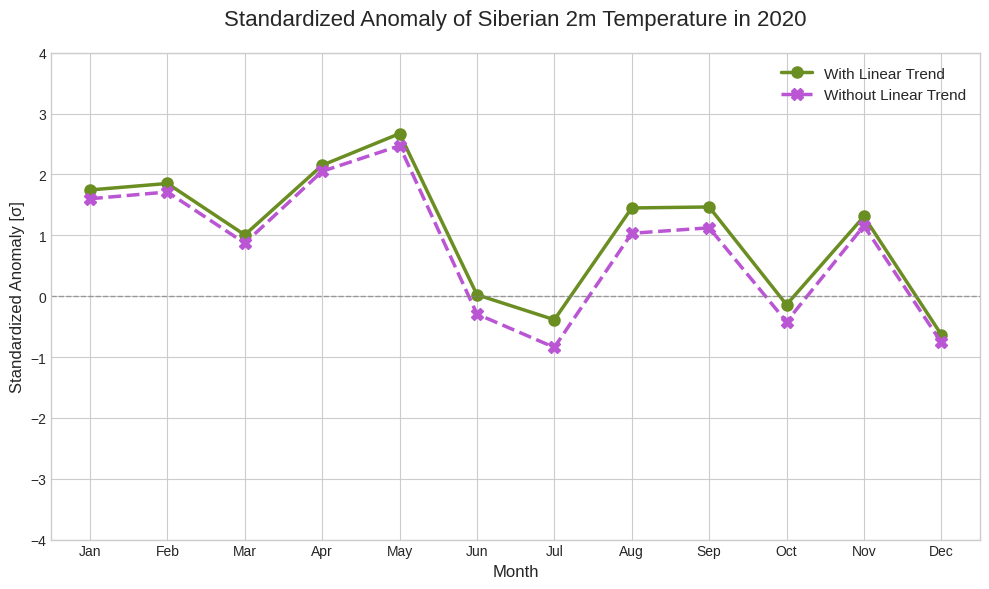

In [8]:
# --- Create Figure and Apply Style ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6)) # Control figure size for better proportions

# --- Plot Data with Enhanced Styling ---
# Plotting the first line (With Trend)
ax.plot(
    std_anom_2020.month, std_anom_2020,
    color='olivedrab',
    marker='o',
    linestyle='-',
    linewidth=2.5, # Slightly thicker line
    markersize=8,  # Larger markers
    label="With Linear Trend"
)

# Plotting the second line (Without Trend)
ax.plot(
    std_anom_detrend_2020.month, std_anom_detrend_2020,
    color='mediumorchid',
    marker='X',
    linestyle='--',
    linewidth=2.5,
    markersize=8,
    label="Without Linear Trend"
)

# --- Formatting and Labels ---
# Add a horizontal line at y=0 for reference
ax.axhline(0, color='grey', linestyle='--', linewidth=1, alpha=0.7)

# Set titles and labels with improved fontsizes
ax.set_title("Standardized Anomaly of Siberian 2m Temperature in 2020", fontsize=16, pad=20)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Standardized Anomaly [σ]", fontsize=12)

# Set axis limits
ax.set_xlim(0.5, 12.5) # Add a little padding to the x-axis
ax.set_ylim(-4, 4)

# Set custom x-axis ticks to show month names
month_labels = [calendar.month_abbr[i] for i in range(1, 13)]
ax.set_xticks(ticks=range(1, 13))
ax.set_xticklabels(month_labels)

# Place legend in the best location automatically
ax.legend(fontsize=11, loc='best')

# Ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.


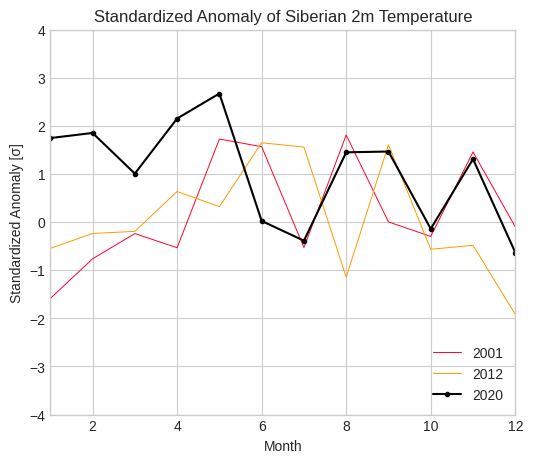

In [9]:
# With Linear Trend
# calculate where 2020 lies in the standard deviation
region=smg.siberia
month_start=1
month_end=12
var='T2M'

ds_regional = smg.select_region_and_time(ds, month_start, month_end, region=region)

# 2. Apply latitude weighting for accurate spatial averaging
weights = np.cos(np.deg2rad(ds_regional.latitude))
weights.name = "weights"

# 3. Select the variable and calculate anomalies based on the climatology for 1951-1980
ds_regional = ds_regional[var]
clim = ds_regional.groupby('time.month').mean(dim='time')
anom = ds_regional.groupby('time.month') - clim

# 4. Spatially average the anomalies to get a single time series
anom = anom.weighted(weights).mean(dim=('longitude', 'latitude'))

# 5. Standardize the anomalies
# The anomaly is standardized by the standard deviation of that month's anomalies
monthly_std = anom.groupby('time.month').std(dim='time')
anom_standardized = anom.groupby('time.month') / monthly_std

base_cmap = plt.get_cmap("gist_rainbow")
color_list = base_cmap(np.linspace(0, 1, 8))
cmap = mcolors.ListedColormap(color_list)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_list)

# Create a boolean DataArray: True if standardized anomaly > 2 sigma
above_threshold = (anom_standardized > 1.5)

# Use rolling sum on the boolean converted to int (True=1, False=0) for summing
cumulative_sum = above_threshold.cumsum()
reset_points = cumulative_sum.where(~above_threshold).ffill(dim='time').fillna(0)
consecutive_counts = cumulative_sum - reset_points # months that aren't above 2 sigma bring the count back down to 0
# Index dates where the counts are above two
consecutive_counts = consecutive_counts.where(consecutive_counts>=2).dropna(dim='time')
consecutive_counts = np.unique(consecutive_counts['time'].dt.year)
# Return as a standard python list
# print('The years with at least two consecutive months above two sigma are: ',sorted(list(consecutive_counts)))
for i, year in enumerate(consecutive_counts):
    ds_year = anom_standardized.sel(time=str(year))
    if year == 2020:
        plt.plot(ds_year.time.dt.month, ds_year,'k.-',label='2020')
    else:
        plt.plot(ds_year.time.dt.month, ds_year,linewidth=0.7,label=str(ds_year.time.dt.year[0].values))#, color=colors[i])

plt.rcParams.update({'figure.figsize': (6,5),
                    'font.size': 10})
plt.xlabel("Month")
plt.xlim(1,12)
plt.legend(loc='lower right')
plt.ylabel("Standardized Anomaly [σ]")
plt.ylim(-4,4)
plt.title("Standardized Anomaly of Siberian 2m Temperature")
plt.savefig('2020siberianheatwave-stdanom-allyears.png')
plt.show()

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.


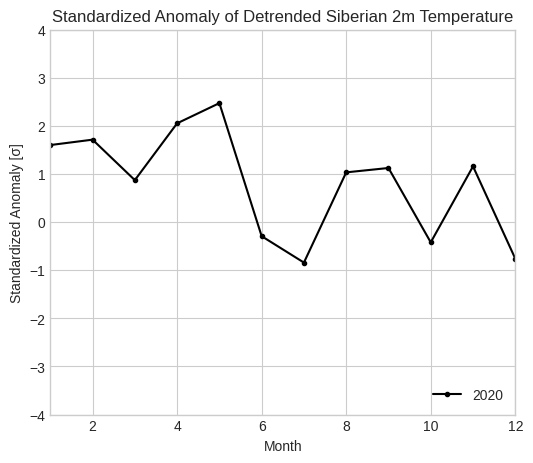

In [10]:
# Detrended
# calculate where 2020 lies in the standard deviation
region=smg.siberia
month_start=1
month_end=12
var='T2M'

ds_regional = smg.select_region_and_time(ds, month_start, month_end, region=region)

# 2. Apply latitude weighting for accurate spatial averaging
weights = np.cos(np.deg2rad(ds_regional.latitude))
weights.name = "weights"

# 3. Select the variable and calculate anomalies based on the climatology for 1951-1980
ds_regional = ds_regional[var]
clim = ds_regional.groupby('time.month').mean(dim='time')
anom = ds_regional.groupby('time.month') - clim

# 4. Spatially average the anomalies to get a single time series
anom = anom.weighted(weights).mean(dim=('longitude', 'latitude'))

# 5. Detrend the resulting time series
anom_detrend = smg.detrend_dataarray(anom)

# 6. Standardize the detrended anomalies
# The anomaly is standardized by the standard deviation of that month's anomalies
monthly_std = anom_detrend.groupby('time.month').std(dim='time')
anom_detrend_standardized = anom_detrend.groupby('time.month') / monthly_std

base_cmap = plt.get_cmap("gist_rainbow")
color_list = base_cmap(np.linspace(0, 1, 8))
cmap = mcolors.ListedColormap(color_list)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_list)

# Create a boolean DataArray: True if standardized anomaly > 2 sigma
above_threshold = (anom_detrend_standardized > 2)

# Use rolling sum on the boolean converted to int (True=1, False=0) for summing
cumulative_sum = above_threshold.cumsum()
reset_points = cumulative_sum.where(~above_threshold).ffill(dim='time').fillna(0)
consecutive_counts = cumulative_sum - reset_points # months that aren't above 2 sigma bring the count back down to 0
# Index dates where the counts are above two
consecutive_counts = consecutive_counts.where(consecutive_counts>=2).dropna(dim='time')
consecutive_counts = np.unique(consecutive_counts['time'].dt.year)
# Return as a standard python list
# print('The years with at least two consecutive months above two sigma are: ',sorted(list(consecutive_counts)))
for i, year in enumerate(consecutive_counts):
    ds_year = anom_detrend_standardized.sel(time=str(year))
    if year == 2020:
        plt.plot(ds_year.time.dt.month, ds_year,'k.-',label='2020')
    else:
        plt.plot(ds_year.time.dt.month, ds_year,linewidth=0.7,label=str(ds_year.time.dt.year[0].values))#, color=colors[i])

plt.rcParams.update({'figure.figsize': (6,5),
                    'font.size': 10})
plt.xlabel("Month")
plt.xlim(1,12)
plt.legend(loc='lower right')
plt.ylabel("Standardized Anomaly [σ]")
plt.ylim(-4,4)
plt.title("Standardized Anomaly of Detrended Siberian 2m Temperature")
plt.savefig('2020siberianheatwave-detrend-stdanom-allyears.png')
plt.show()